In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [4]:
df = pd.read_csv("../Data/Hourly consumption per cluster South Africa.csv")
df["time"] = df["time"].astype(str).str.zfill(3)
df.index = df["time"]
df["day"] = df["time"].str[:1]
df["hour"] = df["time"].str[1:]
df.drop(['time','Unnamed: 0'], axis = 1, inplace = True)
df.head()


,Cluster,consumption_kWh,CO2_intensity,day,hour
time,,,,,
000,0,57.697082,864.524537,0,00
001,0,55.224566,870.705770,0,01
002,0,54.344372,872.777702,0,02
003,0,54.252020,871.116731,0,03
004,0,63.636753,871.232315,0,04


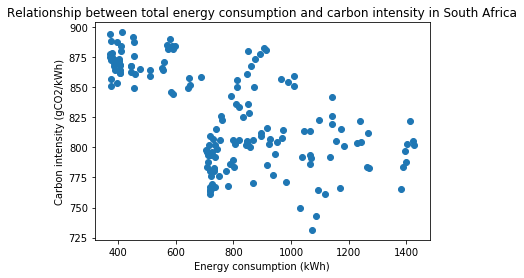

In [8]:
a = df.groupby('time')['consumption_kWh'].apply(lambda x: np.sum(x)).to_frame()

z = df.iloc[range(0,168),-3]
a["CO2_intensity"] = z

plt.scatter(x = a['consumption_kWh'], y = a['CO2_intensity'])
plt.title("Relationship between total energy consumption and carbon intensity in South Africa")
plt.xlabel("Energy consumption (kWh)")
plt.ylabel("Carbon intensity (gCO2/kWh)")
plt.savefig("Carbon Intensity vs Consumption SA.png")

In [6]:
a['consumption_kWh'].corr(a['CO2_intensity'])

-0.5912801422700213